<a href="https://colab.research.google.com/github/sadra-barikbin/persian-sentiment-analysis-example/blob/main/sentiment-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install clean-text[gpl] pytorch-ignite transformers

In [2]:
import numpy as np
import pandas as pd
import cleantext
from imblearn.over_sampling import RandomOverSampler

# Loading & Preparing Data

In [4]:
!gdown 'https://drive.google.com/uc?id=1HH8QFDcvkKfnj4dWmFQceb3PpNqDD8HQ&authuser=0&export=download'
!gdown 'https://drive.google.com/uc?id=1uDOO8RP7Lr9qcRJO8z3d10qm_UggJv4I&authuser=0&export=download'

Downloading...
From: https://drive.google.com/uc?id=1HH8QFDcvkKfnj4dWmFQceb3PpNqDD8HQ&authuser=0&export=download
To: /content/train.csv
100% 171k/171k [00:00<00:00, 52.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uDOO8RP7Lr9qcRJO8z3d10qm_UggJv4I&authuser=0&export=download
To: /content/eval.csv
100% 43.5k/43.5k [00:00<00:00, 12.6MB/s]


In [3]:
train_df = pd.read_csv('train.csv')
eval_df = pd.read_csv('eval.csv')

In [4]:
train_df.head()

,Unnamed: 0,comment,rate
0,2587,پردازنده های Core i5 و Core i3 نیز ذاتا دو هست...,0.0
1,22591,سلام به دوستای عزیزم \nعزاداری هاتون قبول باشه,1.0
2,141037,کلا پولتون رو دور نریزیزد,-1.0
3,58593,از صمیم قلب امیدوارم دایانا با کارن بمونه و پو...,1.0
4,5712,آنطور که اپل ادعا می کند آیپاد شافل دارای طراح...,1.0


In [5]:
eval_df.head()

,Unnamed: 0,comment,rate
0,61591,کیفیت غذا و زمان رسیدن عالی بود,-1.0
1,50299,در‌ حد ساندویچ یه نفره بود نه دونفره یا بمب. ک...,1.0
2,2777,طعم پیتزای چهار فصل مثل همشه خیلی خوب بود اما ...,-1.0
3,9126,مشخصات سخت افزاری مناسب در کنار سیستم عامل وین...,0.5
4,7544,مرغش سوخاری و خوشمزه بود، بسته بندی عالی، قیمت...,-1.0


In [6]:
train_df = train_df.drop(train_df.columns[0], axis=1)
eval_df = eval_df.drop(eval_df.columns[0], axis=1)

In [7]:
print(f"{len(train_df[train_df.rate == 0])} out of {len(train_df)} train comments have rate zero.")
print(f"{len(eval_df[eval_df.rate == 0])} out of {len(eval_df)} eval comments have rate zero.")

104 out of 800 train comments have rate zero.
30 out of 200 eval comments have rate zero.


In [8]:
train_df = train_df[train_df.rate != 0]
eval_df  = eval_df[eval_df.rate != 0]

In [9]:
train_df['rate'] = train_df.rate.apply(lambda r: 1 if r > 0 else 0)
eval_df['rate'] = eval_df.rate.apply(lambda r: 1 if r > 0 else 0)

## Balancing Dataset
As you can see below, data is imbalanced. We use over-sampling strategy on negative class to mitigate the problem.

In [10]:
pd.concat([train_df.rate.value_counts().rename('train'),
           eval_df.rate.value_counts().rename('eval')], axis=1)

,train,eval
1,502,115
0,194,55


In [11]:
balancer = RandomOverSampler(random_state=41)
train_df, _ = balancer.fit_resample(train_df, train_df.rate)
eval_df, _ = balancer.fit_resample(eval_df, eval_df.rate)

## Normalization

In [12]:
params = {'to_ascii':False, 'no_urls':True,    'no_phone_numbers':True, 'no_line_breaks':True,
          'no_emails':True, 'no_numbers':True, 'no_digits':True,        'no_currency_symbols':True}

train_df['comment'] = train_df.comment.apply(lambda c: cleantext.clean(c,**params))
eval_df['comment'] = eval_df.comment.apply(lambda c: cleantext.clean(c,**params))

## Vocabulary

In [13]:
with open("vocab.txt") as fp:
    words = set([w.strip() for w in fp.readlines()])
len(words)

60273

In [ ]:
from nltk.tokenize import word_tokenize

for c in train_df['comment']:
    words.update(word_tokenize(c))

In [16]:
vocab = sorted(words)

In [ ]:
with open('vocab.txt', 'w') as fw:
    for w in vocab:
        fw.write(w + '\n')

In [17]:
len(vocab)

60273

# Method 1: Linear Models
We make use of Logistic Regression and SVM as classifiers, and for vectorizing the comments, Tfidf is used.

## Import Statements

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

In [33]:
vectorizer = TfidfVectorizer(max_features=600, ngram_range=(1,3))

In [34]:
pipeline = Pipeline([('embedding', vectorizer),
                     ('classifier', LinearSVC())])
pipeline.fit(train_df.comment, train_df.rate)

Pipeline(steps=[('embedding',
                 TfidfVectorizer(max_features=600, ngram_range=(1, 3))),
                ('classifier', LinearSVC())])

## Hyper-parameter Tuning
We search over different settings and find the best.

In [ ]:
param_grid = {'embedding__ngram_range': [(1,2),(1,3),(1,4)],
              'embedding__max_features': range(100, 3000, 100),
              'classifier': [LinearSVC(),LogisticRegression()]}

In [ ]:
# The smelling code here is due to Scikit GridSearchCV's specific input for `cv` parameter.
# GridSearchCV and other meta-estimators in Scikit accept whole data (train+eval) in their `fit`
# method. So if you have a dataset separated in train and eval parts beforehand, you should
# concatenate them. Beside that you have to give indices of train and eval parts as the `cv` parameter.

train_eval = pd.concat((train_df, eval_df), ignore_index=True)
train_eval_indices = [(train_df.index, eval_df.index + len(train_df))]
meta_estimator = GridSearchCV(pipeline, param_grid, scoring=['accuracy', 'f1'],
                              cv=train_eval_indices, refit='f1', verbose=1)
_ = meta_estimator.fit(train_eval.comment, train_eval.rate)

Fitting 1 folds for each of 174 candidates, totalling 174 fits


In [ ]:
meta_estimator.best_params_

{'classifier': LinearSVC(),
 'embedding__max_features': 600,
 'embedding__ngram_range': (1, 3)}

In [ ]:
print(f"Best model F1: {meta_estimator.best_score_}")

Best model F1: 0.7063197026022304


## Determining Marker Features

In [ ]:
selector = SelectFromModel(pipeline, threshold=-np.inf, max_features=10, prefit=True,
                           importance_getter='named_steps.classifier.coef_')

pipeline['embedding'].get_feature_names_out()[selector.get_support()]

array(['ارسال', 'اینکه', 'لک', 'معمولی', 'من خیلی', 'میدان', 'نيست',
       'هم که', 'چندان', 'کاملا'], dtype=object)

# Method 2: Neural Networks

In [14]:
import tensorflow as tf

In [18]:
EMBED_DIM = 200
SEQ_LEN = 64
VOCAB_SIZE = len(vocab)
BATCH_SIZE = 20
CLASS_NO = 2

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['comment'], train_df['rate'])).shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
eval_ds = tf.data.Dataset.from_tensor_slices((eval_df['comment'], eval_df['rate'])).shuffle(buffer_size=len(eval_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
from tensorflow.keras.layers import TextVectorization, Embedding, Input, Dense, Bidirectional, LSTM
from tensorflow.keras.models import Sequential

def create_lstm_model(lstm_dim=64, dense_dim=16):
    vectorizer = TextVectorization(vocabulary='vocab.txt',
                                   output_mode='int', 
                                   output_sequence_length=SEQ_LEN)
    return Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Embedding(VOCAB_SIZE + 4, EMBED_DIM, name='embedding'),
        Bidirectional(LSTM(lstm_dim)),
        Dense(dense_dim, activation='relu'),
        Dense(CLASS_NO, 'softmax')
    ])

In [21]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
model = create_lstm_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_m])

In [23]:
len(model.layers[0].get_vocabulary())

60275

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 64)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 64, 200)           12055400  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 12,193,178
Trainable params: 12,193,178
No

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max')

In [26]:
model.fit(train_ds, validation_data=eval_ds, epochs=5)

Epoch 1/5
51/51 [==============================] - 14s 208ms/step - loss: 0.6608 - accuracy: 0.6215 - f1_m: 0.6606 - val_loss: 0.6807 - val_accuracy: 0.5783 - val_f1_m: 0.6719
Epoch 2/5
51/51 [==============================] - 9s 185ms/step - loss: 0.2464 - accuracy: 0.9124 - f1_m: 0.6614 - val_loss: 1.4994 - val_accuracy: 0.5391 - val_f1_m: 0.6589
Epoch 3/5
51/51 [==============================] - 10s 186ms/step - loss: 0.0657 - accuracy: 0.9851 - f1_m: 0.6599 - val_loss: 1.3103 - val_accuracy: 0.6174 - val_f1_m: 0.6688
Epoch 4/5
51/51 [==============================] - 12s 226ms/step - loss: 0.0253 - accuracy: 0.9871 - f1_m: 0.6593 - val_loss: 1.5070 - val_accuracy: 0.5957 - val_f1_m: 0.6513
Epoch 5/5
51/51 [==============================] - 14s 278ms/step - loss: 0.0161 - accuracy: 0.9950 - f1_m: 0.6626 - val_loss: 1.6974 - val_accuracy: 0.6043 - val_f1_m: 0.6573


# Method 3: Pre-trained Language Models

## Import Statements

In [8]:
import torch
from ignite.engine  import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss, Fbeta
from transformers   import BertModel, BertTokenizer
from transformers.models.bert.modeling_bert import BertEncoder
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

if torch.cuda.is_available():
        DEVICE = "cuda"

## Prepare PyTorch Dataset & Data Loader

In [20]:
class SentimentDataset(Dataset):
  def __init__(self,data_frame: pd.DataFrame):
    self.data_frame = data_frame
  def __len__(self):
    return len(self.data_frame)
  def __getitem__(self,idx):
    item = self.data_frame.iloc[idx]
    return item.comment, item.rate


In [26]:
train_ds = SentimentDataset(train_df)
eval_ds = SentimentDataset(eval_df)

train_loader = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True)
eval_loader = DataLoader(eval_ds, batch_size=val_batch_size, shuffle=False)

## Define Model

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self):
    self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-zwnj-base',
                                          output_attentions=False,
                                          add_pooling_layer=False)
    self.cls = nn.ModuleList([nn.Linear(768,70), nn.ReLU(), nn.Flatten(1, -1),
                              nn.AdaptiveMaxPool1d(20), nn.Linear(20, 1), nn.Tanh()])
  def forward(self, input: Dict[str,Tensor]) -> Tensor:
    embedding = self.bert(**input).last_hidden_state
    immediate = embedding
    for layer in self.cls:
      immediate = layer(immediate)
    return immediate.squeeze(dim=-1)

In [ ]:
model = SentimentClassifier().to(DEVICE)

## Optimization Setup

In [ ]:
optimizer_parameter_groups = [
  {'params': list(model.bert.parameters()),'lr': 1e-5},
  {'params': list(model.cls.parameters()), 'lr': 1e-3}
]
optimizer = torch.optim.AdamW(optimizer_parameter_groups)
criterion = nn.BCELoss()

## Train & Evaluation

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=DEVICE)
val_metrics = {"accuracy": Accuracy(), "BCE": Loss(criterion), 'F1': Fbeta(1)}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Final Evaluation

## Import Statements

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score

## Test data preparation

In [1]:
!gdown 'https://drive.google.com/uc?id=1nXjaHjsGDbaPyxQX5-y7D-hfgl6tcomC&authuser=0&export=download'

/usr/bin/sh: line 1: gdown: command not found


In [28]:
test_df = pd.read_csv('test.csv')

In [29]:
test_df.head()

,Unnamed: 0,comment,rate
0,1980,IXY فقط زبان ژاپني انگليسي داره,0.0
1,55810,به نظر من کسی بدون شنیدن یه حرف نمیتونی در اون...,1.0
2,29718,تو وصف این داستان زیبا مثل های شیوای فارسی زیا...,1.0
3,48815,بسیارعالی برای خشکی پوست,1.0
4,6133,البته متاسفانه ابن قابلیت در مورد تمامی برنامه...,-0.5


In [30]:
test_df = test_df.drop(test_df.columns[0], axis=1)

In [31]:
print(f"{len(test_df[test_df.rate == 0])} out of {len(test_df)} test comments have rate zero.")

22 out of 170 test comments have rate zero.


In [32]:
test_df = test_df[test_df.rate != 0]

In [33]:
test_df['rate'] = test_df.rate.apply(lambda r: 1 if r > 0 else 0)

## Normalize Test data

In [34]:
params = {'to_ascii':False, 'no_urls':True,    'no_phone_numbers':True, 'no_line_breaks':True,
          'no_emails':True, 'no_numbers':True, 'no_digits':True,        'no_currency_symbols':True}

test_df['comment'] = test_df.comment.apply(lambda c: cleantext.clean(c,**params))

## Evaluate

### Method 1

In [35]:
predictions = pipeline.predict(test_df.comment)

In [56]:
print(f'Accuracy : {accuracy_score(test_df.rate, predictions)}')
print(f'F1 score : {f1_score(test_df.rate, predictions)}')

Accuracy : 0.7094594594594594
F1 score : 0.7860696517412935


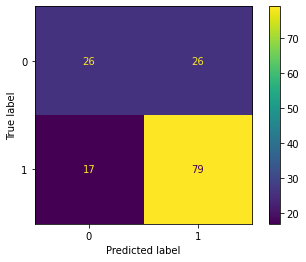

In [53]:
ConfusionMatrixDisplay.from_predictions(test_df.rate, predictions)

### Method 2

In [35]:
test_ds = tf.data.Dataset.from_tensor_slices((test_df['comment'], test_df['rate'])).shuffle(buffer_size=len(test_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 54ms/step - loss: 1.2070 - accuracy: 0.7297 - f1_m: 0.7797


[1.2070481777191162, 0.7297297120094299, 0.7797455191612244]

### Method 3